In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
from PIL import Image
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Init Plugin
Init Graph Optimizer
Init Kernel
Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


In [2]:
train_path = "test_images"
batch_size = 32
resnet152_input_shape = (224, 224)

inceptionV3_input_shape = (299, 299)
os.getcwd()

'/Users/niklashjort/Desktop/Notes/Speciale/projects/MIT_Model'

In [3]:
# import os
# path = '/Users/myName/Desktop/directory'

# count = 0
# for folder in os.listdir(train_path):
#     print(folder)
#     for file in os.listdir(train_path + "/" + folder):
#         print(file)
#         print(len(file))
#         if(len(file)> 25):
#             try:
#                 x = file[:-10] + ".png"
#                 os.rename(train_path + "/" + folder + "/" + file, train_path + "/" + folder + "/" + x)
#                 os.remove(train_path + "/" + folder + "/" + file)
#             except:
#                 pass
#         print(x)

In [4]:
# train_path = "../../../windows_01_only_sz/win_chb_01"
# test_path = "../../../psd_dual_channel_10_patient/windows/test"
# resnet152_input_shape = (224, 224)
# inceptionV3_input_shape = (299, 299)
# batch_size = 20

In [5]:
os.remove(train_path + "/.DS_Store")

In [6]:
for f in os.listdir(train_path):
    print(f)

Seizure
Interictal
Preictal


In [7]:
from tensorflow.keras.applications import VGG16, ResNet152

In [8]:
labels = [item for item in os.listdir(train_path)]
labels

['Seizure', 'Interictal', 'Preictal']

In [9]:
def inspect_class_distribution():
    dist_list = {}
    for i in os.listdir(train_path):
        classname = i
        number_of_png = str(len([x for x in os.listdir(train_path + "/" + i)]))
        #dict = {classname, number_of_png}
        dist_list[classname] =  number_of_png
    return dist_list

inspect_class_distribution()

{'Seizure': '517', 'Interictal': '1813', 'Preictal': '580'}

In [10]:
max_n_images = int(inspect_class_distribution().get('Seizure'))

In [11]:
myList = random.sample(range(1, 100),100-1)

# taking an input list
l1 = []
  
# taking an counter
count = 0
  
# travesing the array
for item in myList:
    if item not in l1:
        count += 1
        l1.append(item)
  
# printing the output
print("No of unique items are:", count)

No of unique items are: 99


In [12]:
path_list = random.sample(os.listdir(train_path + "/Interictal"), 2)

In [13]:
def limit_data(data_dir,n=max_n_images):
    a=[]
    for i in os.listdir(data_dir):
        image_path = random.sample(os.listdir(data_dir+'/'+i), max_n_images)
        for k,j in enumerate(image_path):
            if k>n:continue
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['filename','class'])

In [14]:
balanced_data = limit_data(train_path)

In [15]:
balanced_data.head()

,filename,class
0,test_images/Seizure/chb02_16+_37_T8-P8_11-40-3...,Seizure
1,test_images/Seizure/.DS_Store,Seizure
2,test_images/Seizure/chb02_16_50_F3-C3_09-34-46...,Seizure
3,test_images/Seizure/chb02_16+_12_FP2-F4_11-40-...,Seizure
4,test_images/Seizure/chb02_19_8_FP2-F4_14-47-02...,Seizure


In [16]:
from sklearn.utils import shuffle

balanced_data = shuffle(balanced_data)

In [17]:
print(balanced_data['class'].nunique())
balanced_data['filename'].nunique()

3


1551

In [34]:
model = Sequential()

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(299,299,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 128)      

In [20]:
from tensorflow.keras.applications.resnet import preprocess_input

In [36]:
generator = ImageDataGenerator(
  validation_split=0.2,
  rescale=1.255,
  zoom_range=0.1
)

In [37]:
train_gen = generator.flow_from_dataframe(
    balanced_data,
    batch_size=batch_size, 
    target_size=inceptionV3_input_shape, 
    shuffle=True,
    subset="training")

Found 1240 validated image filenames belonging to 3 classes.


In [38]:
validation_gen = generator.flow_from_dataframe(
    balanced_data,
    batch_size=batch_size, 
    target_size=inceptionV3_input_shape, 
    shuffle=True,
 #   class_mode="binary",
    subset="validation")

Found 309 validated image filenames belonging to 3 classes.


In [24]:
validation_gen.classes

[2,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 2,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 2,


In [39]:
x = 120
train_gen.classes[x:x+10]

[2, 0, 1, 0, 0, 2, 1, 0, 2, 0]

In [26]:
class_weights = {0: 0.4469741480611046,
                1: 1.0266531713900136,
                2: 1.5509683995922527,
                3: 6.947488584474886}

In [27]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(299,299,3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout())
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(4, activation='softmax'))

In [28]:
# model.summary()

In [40]:
from tensorflow.keras.optimizers import Adam, SGD
opt = Adam(0.0001)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=['accuracy']
)

In [30]:
import keras.backend as K
from keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()


import numpy as np
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

ImportError: cannot import name 'LayerNormalization' from 'keras.layers.normalization' (/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/keras/layers/normalization/__init__.py)

In [ ]:
# lr_finder = LRFinder(min_lr=1e-5, 
#                     max_lr=1e-2, 
#                     steps_per_epoch=np.ceil(5/batch_size), 
#                     epochs=3)

In [ ]:
def inspect_class_distribution():
    dist_list = []
    for i in os.listdir(train_path):
        classname = i
        number_of_png = str(len([x for x in os.listdir(train_path + "/" + i)]))
        dict = {classname, number_of_png}
        dist_list.append(dict)
    return dist_list

inspect_class_distribution()

[{'517', 'Seizure'}, {'1811', 'Interictal'}, {'577', 'Preictal'}]

In [42]:
history = model.fit(
    train_gen,
    epochs=20,
    steps_per_epoch = train_gen.samples//batch_size, 
    validation_data=validation_gen, 
    validation_steps = validation_gen.samples//batch_size,
    #callbacks=[lr_finder]
    #class_weight=class_weights
    
)

Epoch 1/20
38/38 [==============================] - 18s 456ms/step - loss: 0.5019 - accuracy: 0.7955 - val_loss: 1.9399 - val_accuracy: 0.5972
Epoch 2/20
38/38 [==============================] - 17s 446ms/step - loss: 0.4644 - accuracy: 0.8245 - val_loss: 1.8690 - val_accuracy: 0.5312
Epoch 3/20
38/38 [==============================] - 17s 446ms/step - loss: 0.3876 - accuracy: 0.8551 - val_loss: 3.2263 - val_accuracy: 0.4583
Epoch 4/20
38/38 [==============================] - 17s 449ms/step - loss: 0.3491 - accuracy: 0.8510 - val_loss: 9.9356 - val_accuracy: 0.3299
Epoch 5/20
38/38 [==============================] - 17s 446ms/step - loss: 0.3443 - accuracy: 0.8733 - val_loss: 4.8286 - val_accuracy: 0.4757
Epoch 6/20
38/38 [==============================] - 17s 448ms/step - loss: 0.2971 - accuracy: 0.8825 - val_loss: 5.2440 - val_accuracy: 0.3785
Epoch 7/20
38/38 [==============================] - 17s 450ms/step - loss: 0.2737 - accuracy: 0.8949 - val_loss: 7.8364 - val_accuracy: 0.3194

In [ ]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(train_path).rglob("*.png")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [ ]:
#lr_finder.plot_loss()

In [ ]:
#model.save("resnet_50ep_cnn.h5")

In [ ]:
with open('history.txt', 'w') as f:
    f.write(str(history.history))

<Figure size 216x288 with 0 Axes>

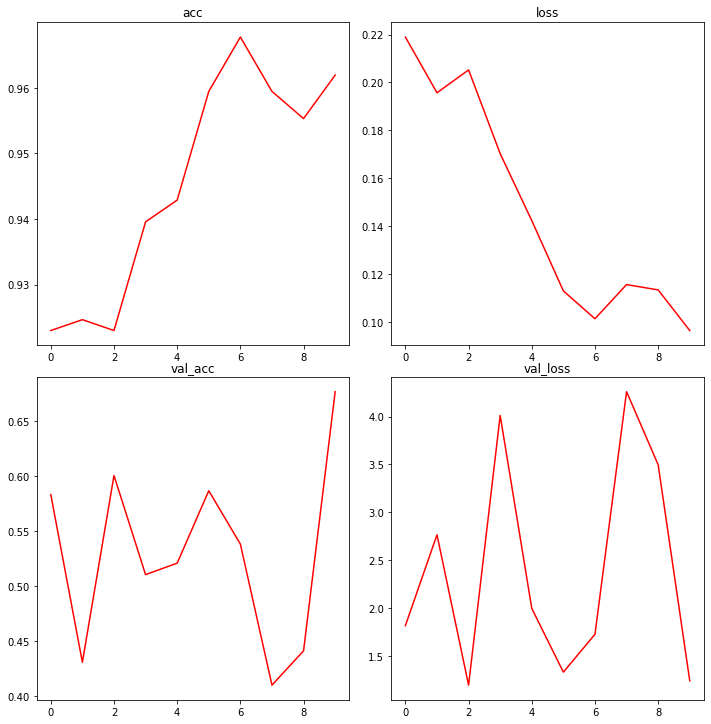

In [ ]:
plt.figure(figsize=(3,4))
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.tight_layout()
axs[0,0].set_title('acc')
axs[0,0].plot(history.history['accuracy'], color='red')
axs[0,1].set_title('loss')
axs[0,1].plot(history.history['loss'], color='red')
axs[1,0].set_title('val_acc')
axs[1,0].plot(history.history['val_accuracy'], color='red')
axs[1,1].set_title('val_loss')
axs[1,1].plot(history.history['val_loss'], color='red')
#plt.savefig("eval.png")

In [ ]:
test_gen = generator.flow_from_dataframe(
    balanced_data,
    batch_size=1, 
    target_size=inceptionV3_input_shape, 
    shuffle=True,
 #   class_mode="binary",
    subset="validation")

In [ ]:
number_of_step = test_gen.samples // 1
number_of_step

In [ ]:
pred = model.predict(test_gen, steps=number_of_step)

In [ ]:
y_pred_max = pred.argmax(axis=-1)

In [ ]:
y_true = test_gen.classes

In [ ]:
for i, x in enumerate(test_gen.classes[0:6]):
    filename = test_gen.filenames[i]
    print(f"index : {i}, y_true : {x} : filename : {filename}")

In [ ]:
labels = ['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure']

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix

In [ ]:
clf_report = classification_report(y_true=y_true, y_pred=y_pred_max, target_names=labels)

In [ ]:
print(clf_report)

In [ ]:
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=list(y_pred_max), normalize='true')

confusion_matrix

In [ ]:
import matplotlib
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels).plot(cmap='Blues')
plt.title("Frozen Layers: 5 Epoch : four patient (all data)=train : validation split = test")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("resnet_only_sz_cb07_test.png")